##### Copyright 2021.7.24 by K同学啊@CSDN.

# 深度卷积生成对抗网络（DCGAN）

## 一、前言

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1

🚀 **深度学习新人必看：**

1. [小白入门深度学习 | 第一篇：配置深度学习环境](https://mtyjkh.blog.csdn.net/article/details/118575238)
2. [小白入门深度学习 | 第二篇：编译器的使用-Jupyter Notebook](https://mtyjkh.blog.csdn.net/article/details/118814364)
3. [小白入门深度学习 | 第三篇：深度学习初体验](https://mtyjkh.blog.csdn.net/article/details/119081309)

## 二、什么是生成对抗网络？

生成对抗网络（GAN）是当今计算机科学领域最有趣的想法之一。两个模型通过对抗过程同时训练。一个生成器模型（“艺术家”）学习创造看起来真实的图像，而判别器模型（“艺术评论家”）学习区分真假图像。


![](./pic_gif/MINST_DCGAN_19.gif)

GAN 的应用十分广泛，它的应用包括图像合成、风格迁移、照片修复以及照片编辑，数据增强等等。

**1）风格迁移**

图像风格迁移是将图像A的风格转换到图像B中去，得到新的图像。

![image.png](./pictures/18-1.png)

**2）图像生成**

GAN 不但能生成人脸，还能生成其他类型的图片，比如漫画人物。

![image.png](./pictures/18-2.png)

### 1. 设置GPU

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")
    
# 打印显卡信息，确认GPU可用
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras  import layers
from IPython           import display
import matplotlib.pyplot as plt
import numpy             as np
import glob,imageio,os,PIL,time

### 2. 加载和准备数据集

您将使用 MNIST 数据集来训练生成器和判别器。生成器将生成类似于 MNIST 数据集的手写数字。

In [3]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

# 将图片标准化到 [-1, 1] 区间内
train_images = train_images / 127.5 - 1  

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE  = 256

# 批量化和打乱数据
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 三、创建模型

### 1. 生成器

生成器使用 `tf.keras.layers.Conv2DTranspose` （上采样）层来从种子（随机噪声）中产生图片。以一个使用该种子作为输入的 `Dense` 层开始，然后多次上采样直到达到所期望的 28x28x1 的图片尺寸。注意除了输出层使用 tanh 之外，其他每层均使用 `tf.keras.layers.LeakyReLU` 作为激活函数。

In [5]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Reshape((7, 7, 256)),
        
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### 2. 判别器

判别器是一个基于 CNN 的图片分类器。

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1)
    ])

    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

## 四、定义损失函数和优化器

为两个模型定义损失函数和优化器。

In [7]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 1. 判别器损失

该方法量化判断真伪图片的能力。它将判别器对真实图片的预测值与值全为 1 的数组进行对比，将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 2. 生成器损失

生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或 1）。这里我们将把判别器在生成图片上的判断结果与一个值全为 1 的数组进行对比。

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

由于我们需要分别训练两个网络，判别器和生成器的优化器是不同的。

In [10]:
generator_optimizer     = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 五、定义训练循环


In [11]:
EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 16

# 我们将重复使用该种子（在 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

训练循环在生成器接收到一个随机种子作为输入时开始。该种子用于生产一张图片。判别器随后被用于区分真实图片（选自训练集）和伪造图片（由生成器生成）。针对这里的每一个模型都计算损失函数，并且计算梯度用于更新生成器与判别器。

In [12]:
# 注意 `tf.function` 的使用
# 该注解使函数被“编译”
@tf.function
def train_step(images):
    # 生成噪音
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # 计算loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    #计算梯度
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    #更新模型
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # 实时更新生成的图片
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # 最后一个 epoch 结束后生成图片
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

**生成与保存图片**


In [17]:
def generate_and_save_images(model, epoch, test_input):
    # 注意 training` 设定为 False
    # 因此，所有层都在推理模式下运行（batchnorm）。
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./images/19/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

## 六、训练模型
调用上面定义的 `train()` 方法来同时训练生成器和判别器。在训练之初，生成的图片看起来像是随机噪声。随着训练过程的进行，生成的数字将越来越真实。在大概 50 个 epoch 之后，这些图片看起来像是 MNIST 数字。

`%%time`：将会给出cell的代码运行一次所花费的时间。

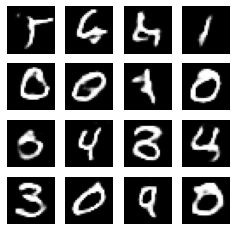

Wall time: 4min 46s


In [19]:
%%time
train(train_dataset, EPOCHS)

## 七、创建 GIF


In [1]:
import imageio,pathlib

def compose_gif():
    # 图片地址
    data_dir = "./images/19"
    data_dir = pathlib.Path(data_dir)
    paths    = list(data_dir.glob('*'))
    
    gif_images = []
    for path in paths:
        gif_images.append(imageio.imread(path))
    imageio.mimsave("./pic_gif/MINST_DCGAN_19.gif",gif_images,fps=8)
    
compose_gif()
print("GIF动图生成完成！")

GIF动图生成完成！


![](./pic_gif/MINST_DCGAN_19.gif)

## 八、同系列作品

🚀 **深度学习新人必看：**

1. [小白入门深度学习 | 第一篇：配置深度学习环境](https://mtyjkh.blog.csdn.net/article/details/118575238)
2. [小白入门深度学习 | 第二篇：编译器的使用-Jupyter Notebook](https://mtyjkh.blog.csdn.net/article/details/118814364)
3. [小白入门深度学习 | 第三篇：深度学习初体验](https://mtyjkh.blog.csdn.net/article/details/119081309)